In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/CV_ENG_8160/Module06'

/content/drive/MyDrive/CV_ENG_8160/Module06


In [3]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# !gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
# !gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

In [5]:
# !unzip 'train.zip' -d '.'
# !unzip 'test.zip' -d '.'

In [6]:
# add hour dimension to train data
# compare LSTM to GRU: window = 10,36, horizon = 36

In [7]:
class TrafficForecast(Dataset):
    def __init__(self, pkl_path, window, horizon):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.train_inputs = []
        self.train_targets = []
        self.test_inputs = []
        self.test_targets = []

        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.seg_ids = self.df['segmentID'].unique()

        # split into train and test: 80 to 20
        train_ratio = 0.8
        train_size = int(len(self.seg_ids) * train_ratio)
        train_seg_ids = self.seg_ids[:train_size]
        test_seg_ids = self.seg_ids[train_size:]

        self.setup_forecast(train_seg_ids, train=True)  # Setup training data
        self.setup_forecast(test_seg_ids, train=False)  # Setup testing data

    def setup_forecast(self, seg_ids, train=True):
        for segid in seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time', ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")  # [1, nan, nan, nan, 2, 3, 4]
            TI_series = df_seg_id['TrafficIndex_GP'].values
            hour_series = df_seg_id['hour'].values
            for t in range(0, len(TI_series) - (self.window + self.horizon)):
                x = TI_series[t:t + self.window]
                h = hour_series[t:t + self.window]
                y = TI_series[t + self.window:(t + self.window + self.horizon)]

                x_cat = np.dstack([x, h])

                if train:
                    self.train_inputs.append(x_cat)
                    self.train_targets.append(y)
                else:
                    self.test_inputs.append(x_cat)
                    self.test_targets.append(y)

    def __len__(self, train=True):
        if train:
            return len(self.train_inputs)
        else:
            return len(self.test_inputs)

    def __getitem__(self, idx, train=True):
        if train:
            X = torch.tensor(self.train_inputs[idx], dtype=torch.float32).reshape(self.window, 2)
            y = torch.tensor(self.train_targets[idx], dtype=torch.float32)
        else:
            X = torch.tensor(self.test_inputs[idx], dtype=torch.float32).reshape(self.window, 2)
            y = torch.tensor(self.test_targets[idx], dtype=torch.float32)

        return {'inputs': X, 'outputs': y}


In [8]:
tobj = TrafficForecast('tps_df.pkl',36,36)

In [9]:
print(tobj.train_inputs[0].shape)

(1, 36, 2)


In [10]:
bs = 1024
# dataloader_train = DataLoader(tobj, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_train = DataLoader(tobj, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
      break

torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
from models import MyLSTM, MyGRU

In [14]:
model = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid valu

Epoch 1/3, Training Loss: 0.0707


 67%|██████▋   | 2/3 [01:04<00:32, 32.16s/it]

Epoch 2/3, Training Loss: 0.0403


100%|██████████| 3/3 [01:39<00:00, 33.04s/it]

Epoch 3/3, Training Loss: 0.0301


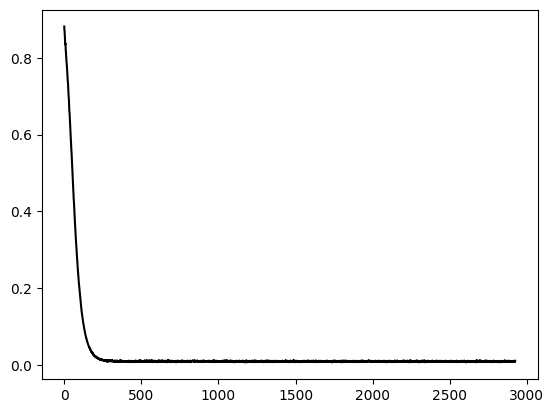

In [16]:
plt.plot(losses,'k',label='training')

In [18]:
torch.save(model.state_dict(), 'grumodel.pt')

In [22]:
model_arch.eval()

MyGRU(
  (relu): ReLU()
  (rnn): GRU(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [23]:
model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
mean_loss = []
lstm_train_losses = []
lstm_test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    lstm_train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(lstm_train_losses))
  mean_test_loss.append(np.mean(lstm_test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(lstm_train_losses):.4f}')

 33%|███▎      | 1/3 [00:32<01:04, 32.33s/it]

Epoch 1/3, Training Loss: 0.0078


 67%|██████▋   | 2/3 [01:04<00:32, 32.41s/it]

Epoch 2/3, Training Loss: 0.0077


100%|██████████| 3/3 [01:40<00:00, 33.56s/it]

Epoch 3/3, Training Loss: 0.0077


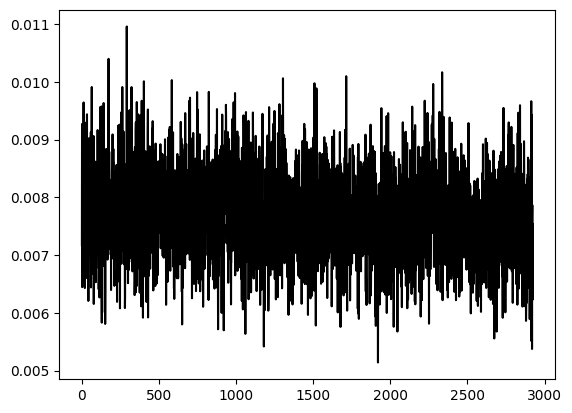

In [29]:
plt.plot(lstm_train_losses,'k',label='training')

In [30]:
torch.save(model.state_dict(), 'lstmmodel.pt')

In [32]:
print(model)

MyLSTM(
  (relu): ReLU()
  (rnn): LSTM(2, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)
